# Traffic Sign Recognition Classifier

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
tf.version.VERSION

'2.7.0'

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
assert(physical_devices)

In [5]:
print(physical_devices)
if len(physical_devices):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# imports
import numpy as np
import pickle
import os

In [7]:
output_dir = "./output" # directory for generated graphics and images

In [8]:
seed = 0
tf.keras.utils.set_random_seed(
    seed
)


---
## Loading traffic sign data 

In [9]:
# Load pickled data

data_dir = "./traffic-signs-data"
training_file = os.sep.join([data_dir, "train.p"])
validation_file= os.sep.join([data_dir, "valid.p"])
testing_file = os.sep.join([data_dir, "test.p"])

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [10]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from traffic_sign_classifier.utils import group_by_category, load_signnames
# Loading the classes/categories names
class2label = load_signnames(os.sep.join([data_dir, "signnames.csv"]))

# by_category_sample = group_by_category(y_train)

In [13]:
os.path.join(output_dir, "images_preview.jpg")

'./output/images_preview.jpg'

#### Traffic sign images preview for all the classes

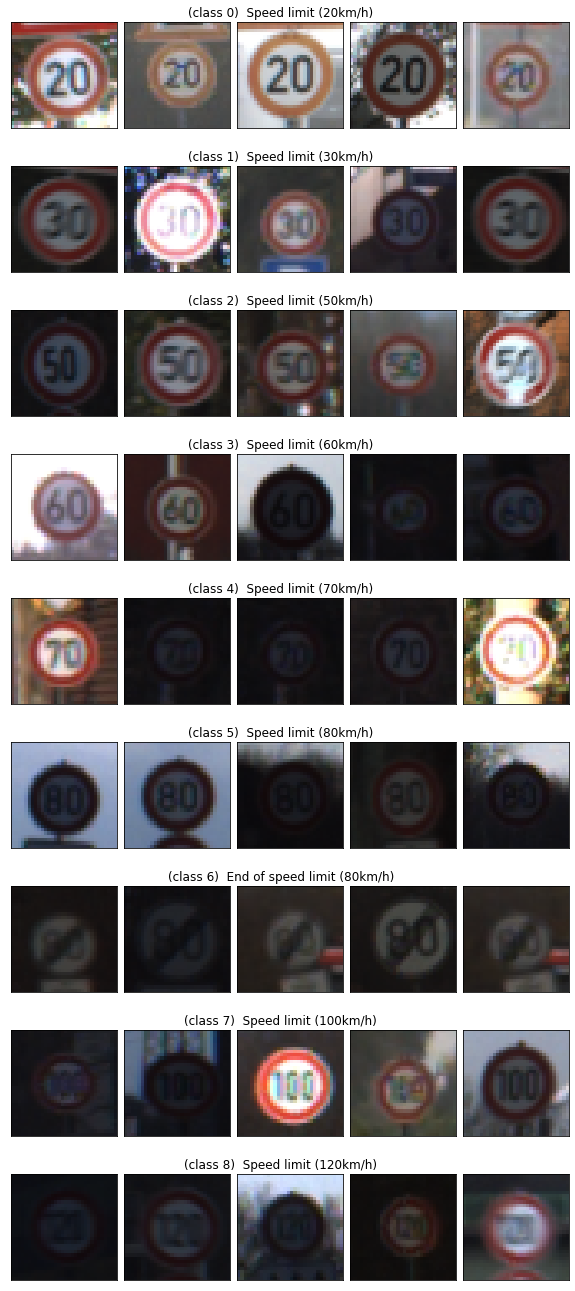

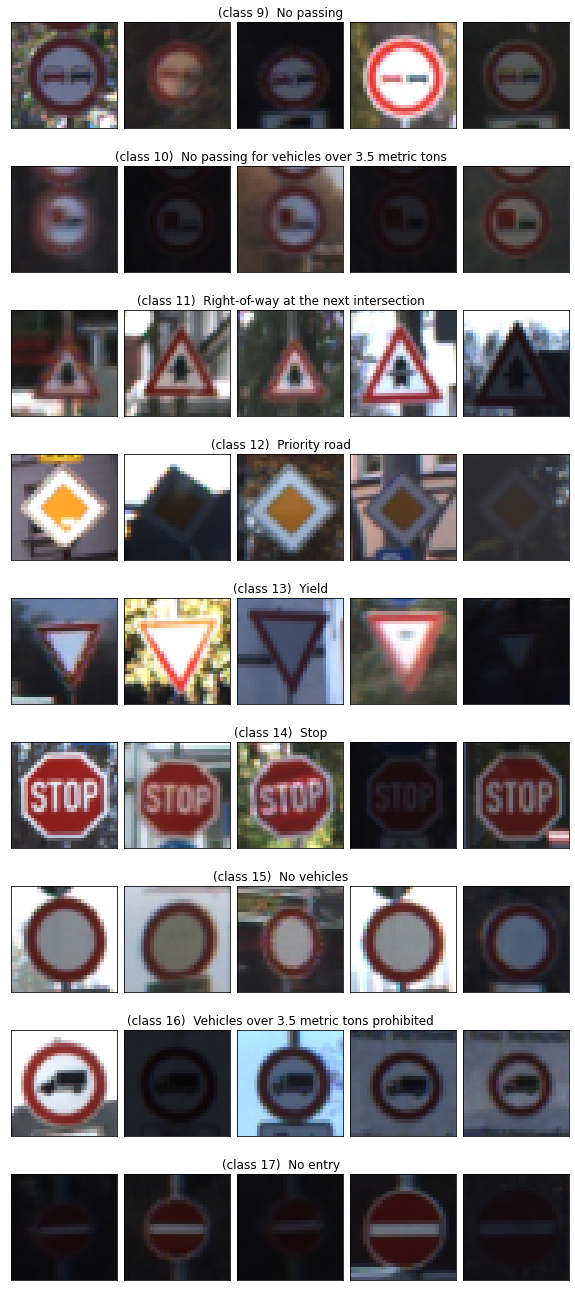

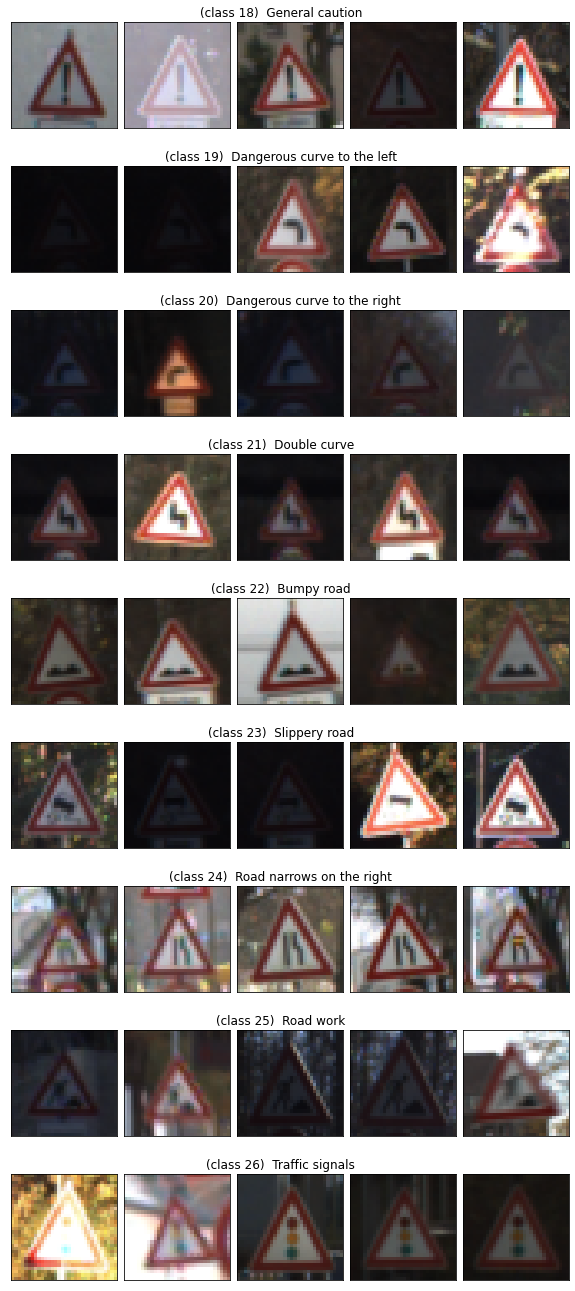

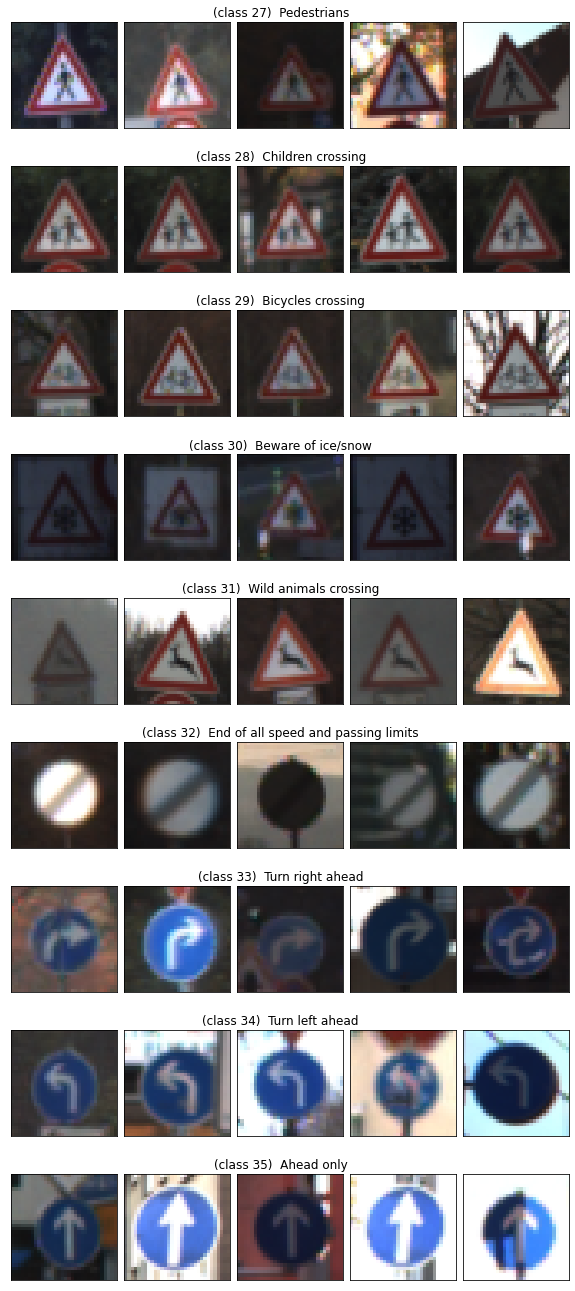

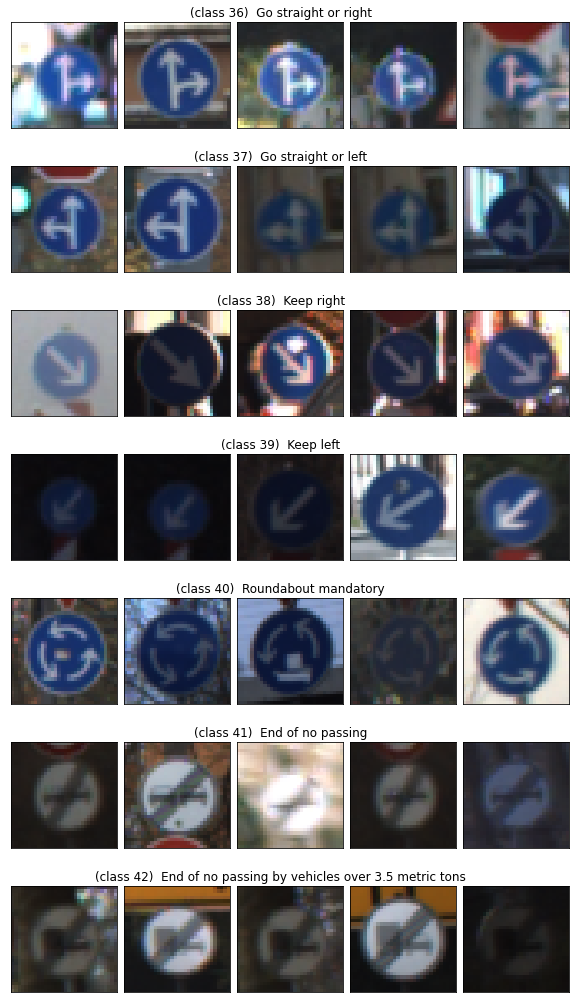

In [14]:
from traffic_sign_classifier.visualization import grid_visu

grid_visu(X_train, labels=y_train, sample_size=5, categories_per_fig=9, # , categories=range(10),
          label_to_name=class2label,
          shuffle=True, output_dir_path="./output/previews")

#### Categories/classes distribution (in train/validation/test)

In [15]:
# Grouping dataset by categories using the labels
category_grouped_datasets = {} # A dictionary per datatset grouping the sample with their attributes
for dataset, data_ in [ ("train", y_train), ("test", y_test), ("validation", y_valid)]:
    print(f"{dataset} data set size -> {len(data_)}")
    category_grouped_datasets[dataset] = group_by_category(data_) 

train data set size -> 34799
test data set size -> 12630
validation data set size -> 4410


In [16]:
# Categories/classese distribution (in train/validation/test)
from collections import defaultdict
from typing import Optional

def  visualize_datasets_distribution(category_grouped_datasset_dict, output_dir:str =output_dir, output_file_name:Optional[str]=None):
    """ A helper to visualize datasets distribution """
    plt.figure(figsize=(10, 16))
    bar_width = 0.3
    width_offset = 0
    for dataset, by_category in  category_grouped_datasset_dict.items():
        # Plotting 
        categories, sizes = zip(*[(category, len(items)) for category, items in sorted(by_category.items(), key=lambda x: len(x[1]), reverse=False)])
        plt.barh([width_offset + item for item in range(len(categories))], sizes, height=bar_width,
                 tick_label=[class2label.get(item, item) for item in categories],
                 label=f"{dataset} dataset")
        width_offset += bar_width
    plt.legend()
    plt.title(f"Train/validation/test classes distribution")
    plt.grid()
    # Saving the figure to a file (file should ends png)
    if isinstance(output_file_name, str) and output_file_name.endswith(".png"):
        plt.savefig(os.path.join(output_dir,output_file_name))

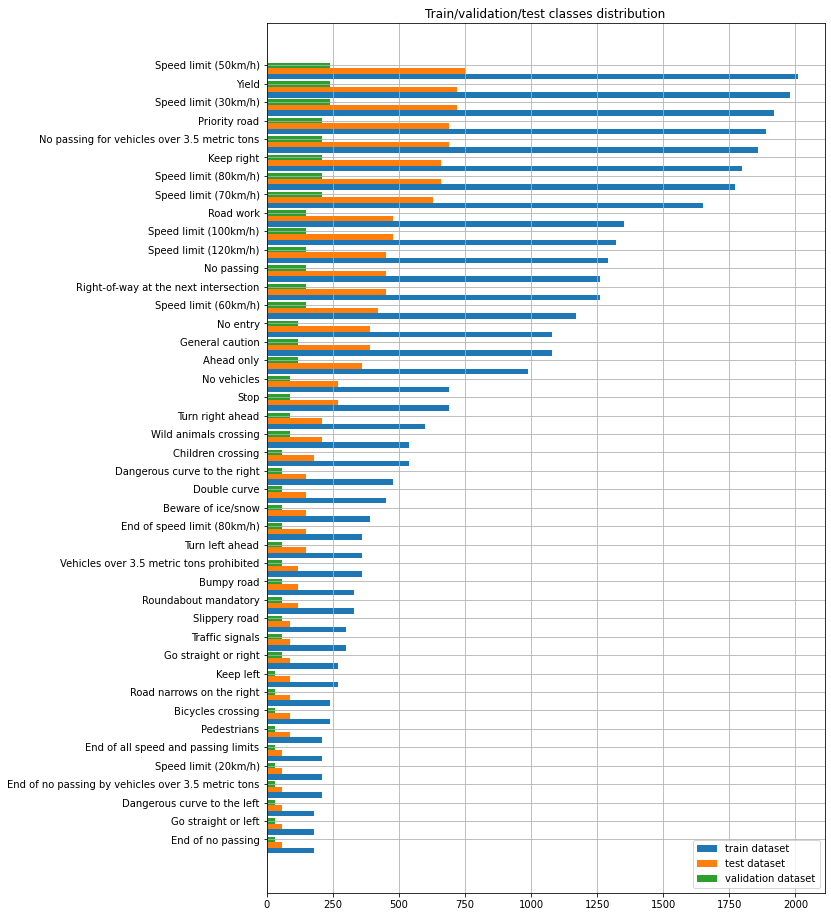

In [17]:
visualize_datasets_distribution(category_grouped_datasets, output_file_name="classes_distribution.png")

## Pre-process the Data Set

Minimally, the image data should be normalized so that the data has mean zero and equal variance. An apporximation is done by centralizing and scaling impemented as a preprocessing layers of the neural network (see `preprocessing_layers` intialization in  Model architecture section).


Here we will augment the data generating sample from random transformation applyied on the classes with few training examples/samples. 


Optionally during the training data augmentation layers are used to alter the data making the model a bit more robust to some transformation change/range. (see training model section)

In [18]:
from functools import reduce
from sklearn.utils import resample

In [19]:
# Selecting categories with few example to augment
# Let's select all the category below `category_size_threshold` example in the training and 
# generate the complementary to `category_size_threshold` to add 

category_size_threshold = 600

to_augment = {category: resample(items, n_samples=max(200, category_size_threshold-len(items)), replace=True, stratify=items) for category, items in 
              sorted(category_grouped_datasets["train"].items(), key=lambda x: len(x[1])) # if len(items)< category_size_threshold
             }


In [20]:
to_augment_items = reduce(lambda x, y: x+y, to_augment.values()) 

In [21]:
# Visualize items to augment (when only a subset of classes is chosen )

# grid_visu(X_train[to_augment_items], labels=y_train[to_augment_items], sample_size=5, categories_per_fig=5,
#           label_to_name=class2label,
#           shuffle=True, output_dir_path="./output/to_augment")

### Generating and balancing data

In [22]:
# Generate augmented (transformed data) dataset from the resampled data ( categories with few examples < category_size_threshold)
from tensorflow.keras.layers import RandomRotation, Rescaling, Resizing, GaussianNoise
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, CenterCrop
from tensorflow.keras.layers import RandomTranslation, RandomContrast, RandomZoom, RandomContrast
from tensorflow.keras import Sequential


# Define augmentation layers 
augmentation_layers = [
    RandomRotation(.02), 
    # GaussianNoise(4, 0, dtype='uint8')
    RandomTranslation(.1, .1),
    RandomZoom(height_factor=(-0.1, -0.0)),
    RandomContrast(.1)
    ]

augmentation = Sequential(augmentation_layers)

generated = (tf.data.Dataset.from_tensor_slices((X_train[to_augment_items], y_train[to_augment_items])).
             batch(256).map(lambda x, y: (augmentation(x, training=True), y),  num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
            )


In [23]:
from collections import Counter
categories_counter = Counter()

# Collecting the generated data

gen_X = []
gen_y = []
for batch_X, batch_y in  generated:
    gen_X.append(np.array(batch_X))
    gen_y.append(np.array(batch_y))
    categories_counter.update(np.array(batch_y))


gen_X = np.concatenate(gen_X)
gen_y = np.concatenate(gen_y)


# Append it to the original data as (augmented)

print(f" augmentation -> {categories_counter}")

augmented_X = np.concatenate((X_train, gen_X))
augmented_y = np.concatenate((y_train, gen_y))

augmented_sample_per_category = Counter(augmented_y)
print(f" augmented -> {augmented_sample_per_category}")


# A Sanity check (after merge all the category should at least have `category_size_threshold` samples)
assert(all([cnt >= category_size_threshold for _, cnt in augmented_sample_per_category.items()]))     

 augmentation -> Counter({37: 420, 19: 420, 0: 420, 41: 390, 42: 390, 32: 390, 27: 390, 29: 360, 24: 360, 39: 330, 21: 330, 40: 300, 20: 300, 36: 270, 22: 270, 16: 240, 34: 240, 6: 240, 30: 210, 23: 200, 28: 200, 26: 200, 15: 200, 33: 200, 31: 200, 14: 200, 17: 200, 35: 200, 18: 200, 11: 200, 3: 200, 8: 200, 7: 200, 9: 200, 25: 200, 5: 200, 4: 200, 10: 200, 38: 200, 12: 200, 13: 200, 1: 200, 2: 200})
 augmented -> Counter({2: 2210, 1: 2180, 13: 2120, 12: 2090, 38: 2060, 10: 2000, 4: 1970, 5: 1850, 25: 1550, 9: 1520, 7: 1490, 3: 1460, 8: 1460, 11: 1370, 35: 1280, 18: 1280, 17: 1190, 31: 890, 14: 890, 33: 799, 26: 740, 15: 740, 28: 680, 23: 650, 41: 600, 36: 600, 40: 600, 22: 600, 37: 600, 16: 600, 19: 600, 42: 600, 0: 600, 32: 600, 27: 600, 29: 600, 24: 600, 34: 600, 6: 600, 30: 600, 39: 600, 21: 600, 20: 600})


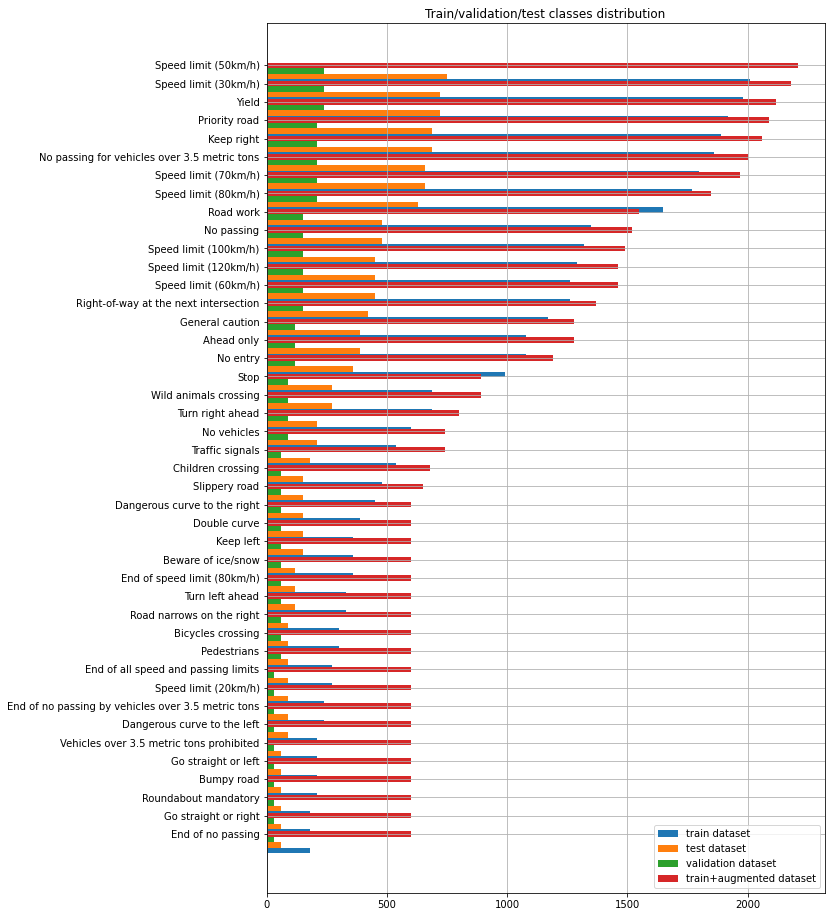

In [24]:
category_grouped_datasets["train+augmented"] = group_by_category(augmented_y)
visualize_datasets_distribution(category_grouped_datasets, output_file_name="classes_distribution_with_augmented.png")

### Visualize generated samples per category

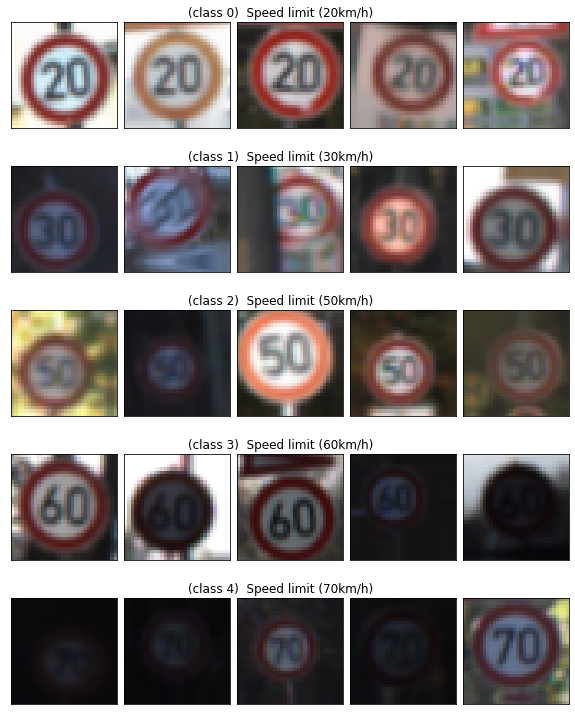

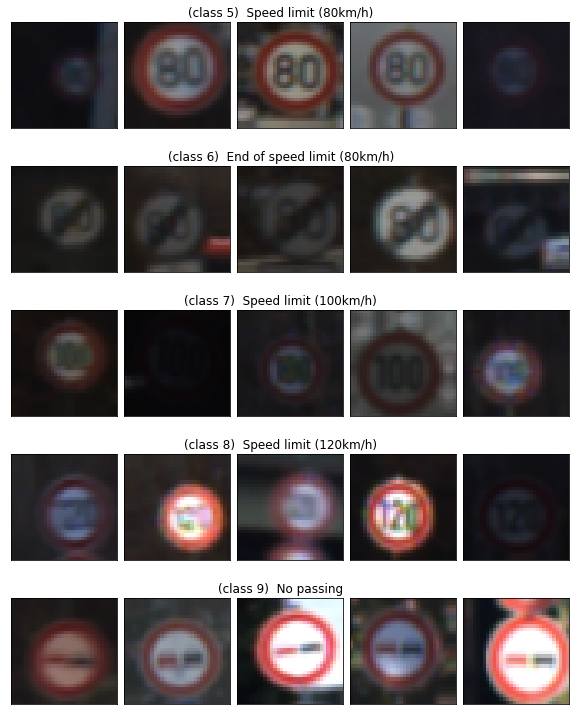

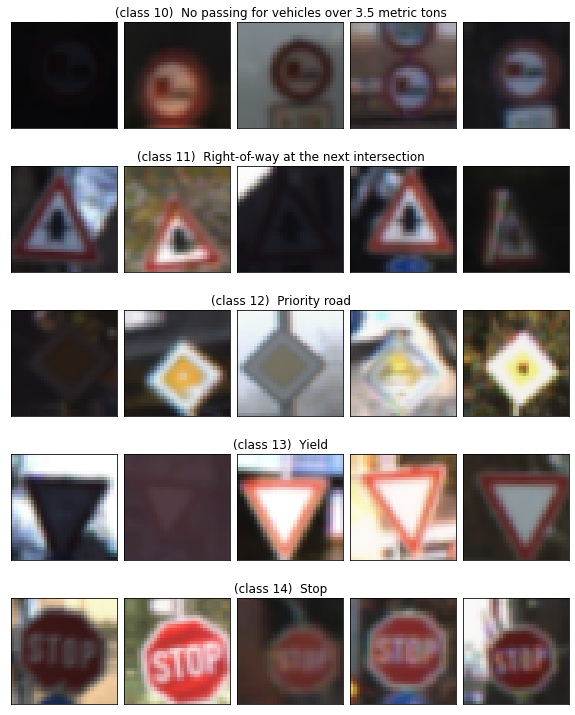

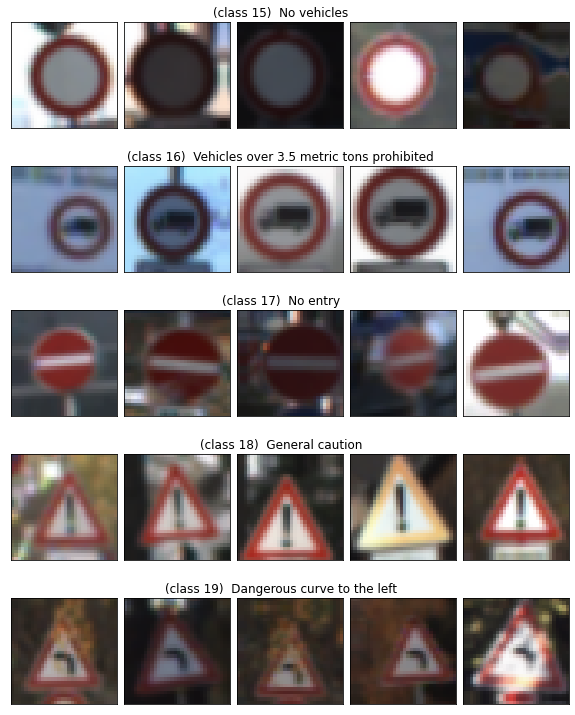

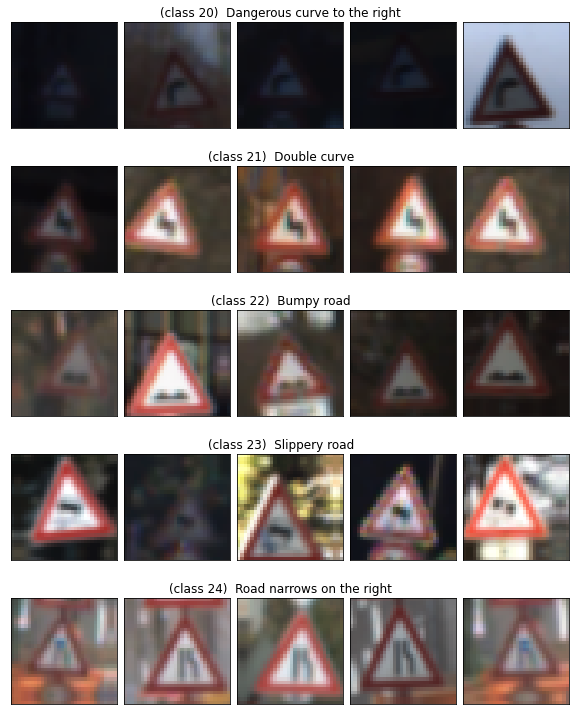

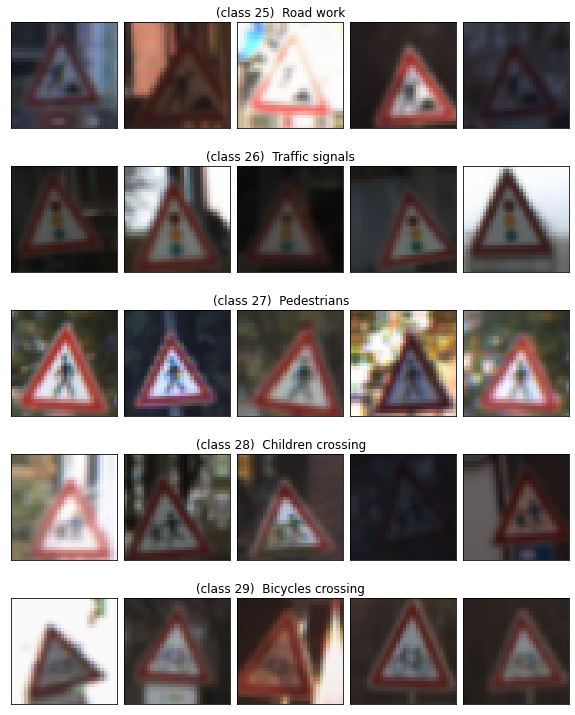

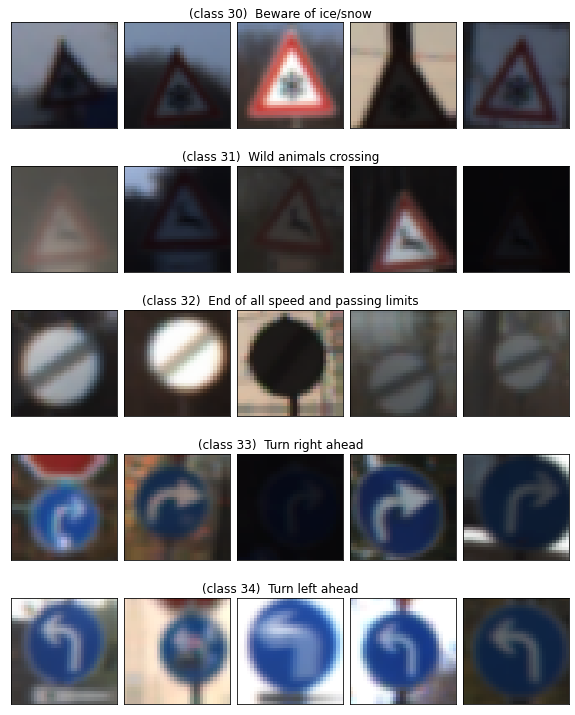

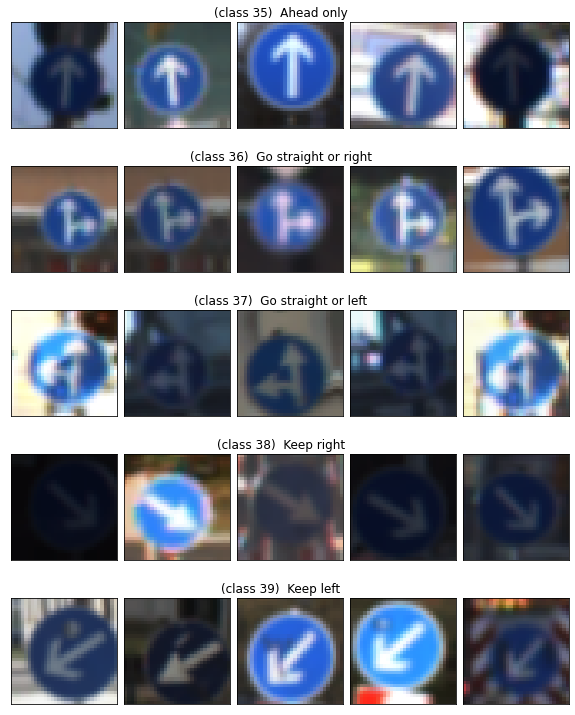

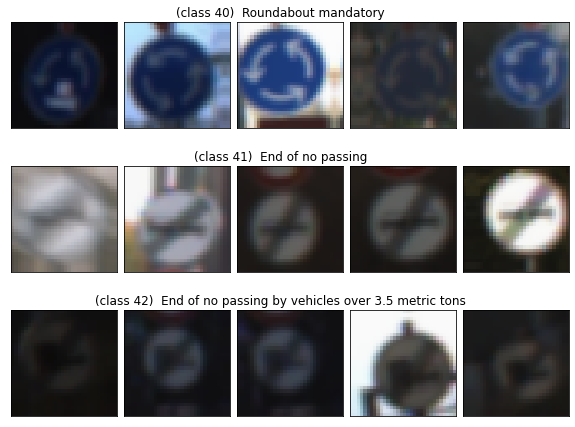

In [25]:
grid_visu(np.array(gen_X), labels=list(gen_y), sample_size=5, categories_per_fig=5,
      label_to_name=class2label,
      shuffle=True, output_dir_path="./output/augmentation_generation")


## Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


Model requirements:

To meet specifications, the validation set accuracy will need to be at least 0.93.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

An example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

In [26]:
# from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import RandomRotation, Rescaling, Resizing, GaussianNoise

### Model Architecture

Le Net is chosen to be the baseline architecture. Augmentation and slightly variated architecture are evaluated for performance gain.

In [27]:
from traffic_sign_classifier.nn.lenet import LeNet, ConvLayerConfig
from datetime import datetime


In [28]:
preprocessing_layers = [
  Resizing(32, 32),
  Rescaling(scale=1./127.5, offset=-1)
]

In [29]:
# Setting up networks (and models) to compare
# TODO: add a Gray-Level model
# TODO: use model name to name layers


logits = False # append a Softmax activation ! set to true to keep the logits output

networks = {
        "tsc_baseline": LeNet(categ_nbr=n_classes, logits=logits,
                              preprocessing_layers = preprocessing_layers,
                              name="tsc_baseline",
                              batch_norm=False,
                              dropout=0)
                            ,
        "tsc_lenet_batch-norm_dropout": LeNet(categ_nbr=n_classes, logits=logits,
                               preprocessing_layers = preprocessing_layers,
                               name="tsc_lenet_batch-norm_dropout"),
        "tsc_lenet_always_augment": LeNet(categ_nbr=n_classes, logits=logits,
                                                 preprocessing_layers = preprocessing_layers,
                                                 augmentation_layers= augmentation_layers,
                                        name="tsc_lenet_always_augment"),

            "tsc_lenet_more_filters":
                LeNet(categ_nbr=n_classes, logits=logits,
                      preprocessing_layers = preprocessing_layers,
                     
                      conv_layers_config = {
                            1: ConvLayerConfig(filters=12, kernel_size=(5, 5)),
                            2: ConvLayerConfig(filters=32, kernel_size=(5, 5)),
                            },
                       name="tsc_lenet_more_filters",
                     ),
                "tsc_lenet_7x7_more_filters":
                LeNet(categ_nbr=n_classes, logits=logits,
                      preprocessing_layers = preprocessing_layers,
                     
                      conv_layers_config = {
                            1: ConvLayerConfig(filters=12, kernel_size=(7, 7)),
                            2: ConvLayerConfig(filters=32, kernel_size=(7, 7)),
                            },
                       name="tsc_lenet_7x7_more_filters",
                     ),
                    "tsc_lenet_11x11_more_filters":
                LeNet(categ_nbr=n_classes, logits=logits,
                      preprocessing_layers = preprocessing_layers,
                     
                      conv_layers_config = {
                            1: ConvLayerConfig(filters=12, kernel_size=(11, 11)),
                            2: ConvLayerConfig(filters=32, kernel_size=(7, 7)),
                            },
                       name="tsc_lenet_11x11_more_filters",
                     )
            
           }

In [30]:
# Include network name in layer naming
# TODO summary to md 

def md_summary(model):
    for layer in model.layers:
        print(f"{layer.name}{layer.__class__}")

md_summary(networks.get("tsc_lenet_more_filters"))
        

conv2d_6<class 'keras.layers.convolutional.Conv2D'>
batch_normalization_4<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
max_pooling2d_6<class 'keras.layers.pooling.MaxPooling2D'>
conv2d_7<class 'keras.layers.convolutional.Conv2D'>
batch_normalization_5<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
max_pooling2d_7<class 'keras.layers.pooling.MaxPooling2D'>
flatten_3<class 'keras.layers.core.flatten.Flatten'>
dropout_2<class 'keras.layers.core.dropout.Dropout'>
dense_9<class 'keras.layers.core.dense.Dense'>
dense_10<class 'keras.layers.core.dense.Dense'>
dense_11<class 'keras.layers.core.dense.Dense'>


In [31]:
# init models
for name , network in  networks.items():
    # setup model with arbitrary image size as input (arch. already setup to resize)
    print(f"building (models) for {name}")
    network.build_models(input_=tf.keras.Input(shape=(None, None, 3)))
    network.model.summary()
    
    # network.pred_model.summary()


building (models) for tsc_baseline
Model: "tsc_baseline.training"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
          

Model: "tsc_lenet_11x11_more_filters.training"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 12)        4368      
                                                                 
 batch_normalization_8 (Batc  (None, 22, 22, 12)       48        
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 11, 11, 12)       0         
 g2D)                        

# Add loss and compile model

In [32]:
optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

for _, network in  networks.items():
    network.compile_model(optimizer=optimizer, metrics=["accuracy"])

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validationsets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [33]:
assert(set(augmented_y)==set(y_valid)) # a sanity check that all the labels appear in both train and validation

y_train_categorical = to_categorical(augmented_y)
y_valid_categorical = to_categorical(y_valid)

In [34]:
# Sanity check
assert y_train_categorical.shape[1] == y_valid_categorical.shape[1]

In [35]:
y_train_categorical.shape

(45869, 43)

In [36]:
# Shuffling (also could be done within the training it self, but better externally for better model comparability)

### Setting-up callbacks

In [37]:

# Tensor board setup
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [38]:
# Set early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [39]:
from collections import defaultdict

history = defaultdict(lambda: [])  # to support interactive training: multi-round of multiple epochs.

### Training

In [40]:
EPOCHS = 50
BATCH_SIZE = 256 # to variate the batch_size

# Train all the test networks (sequentially)

for name, network in networks.items():
    print(f"training -> {name}")
    history[name].append(network.model.fit(augmented_X,  y_train_categorical,
        validation_data=(X_valid,  y_valid_categorical), shuffle=True, # TODO: shuffle externally and set shuffle to False
        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard_callback, early_stopping_callback]))

training -> tsc_baseline
Epoch 1/50
180/180 [==============================] - 7s 15ms/step - loss: 1.6365 - accuracy: 0.5487 - val_loss: 0.7914 - val_accuracy: 0.7723
Epoch 2/50
180/180 [==============================] - 2s 13ms/step - loss: 0.5207 - accuracy: 0.8562 - val_loss: 0.6042 - val_accuracy: 0.8447
Epoch 3/50
180/180 [==============================] - 2s 13ms/step - loss: 0.3023 - accuracy: 0.9160 - val_loss: 0.5235 - val_accuracy: 0.8946
Epoch 4/50
180/180 [==============================] - 2s 13ms/step - loss: 0.2063 - accuracy: 0.9426 - val_loss: 0.5631 - val_accuracy: 0.8744
Epoch 5/50
180/180 [==============================] - 2s 13ms/step - loss: 0.1488 - accuracy: 0.9583 - val_loss: 0.5948 - val_accuracy: 0.8844
Epoch 6/50
180/180 [==============================] - 2s 13ms/step - loss: 0.1125 - accuracy: 0.9679 - val_loss: 0.6791 - val_accuracy: 0.8703
Epoch 7/50
180/180 [==============================] - 2s 13ms/step - loss: 0.0925 - accuracy: 0.9736 - val_loss: 0.49

180/180 [==============================] - 3s 15ms/step - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.3924 - val_accuracy: 0.9229
Epoch 19/50
180/180 [==============================] - 3s 14ms/step - loss: 0.0468 - accuracy: 0.9844 - val_loss: 0.2712 - val_accuracy: 0.9422
Epoch 20/50
180/180 [==============================] - 3s 15ms/step - loss: 0.0343 - accuracy: 0.9884 - val_loss: 0.3164 - val_accuracy: 0.9406
Epoch 21/50
180/180 [==============================] - 3s 15ms/step - loss: 0.0392 - accuracy: 0.9874 - val_loss: 0.3095 - val_accuracy: 0.9392
Epoch 22/50
180/180 [==============================] - 3s 15ms/step - loss: 0.0351 - accuracy: 0.9882 - val_loss: 0.3253 - val_accuracy: 0.9315
Epoch 23/50
180/180 [==============================] - 3s 16ms/step - loss: 0.0366 - accuracy: 0.9882 - val_loss: 0.5929 - val_accuracy: 0.8955
Epoch 24/50
180/180 [==============================] - 3s 15ms/step - loss: 0.0319 - accuracy: 0.9898 - val_loss: 0.4607 - val_accuracy: 0.9193
Epoc

Epoch 25/50
180/180 [==============================] - 5s 29ms/step - loss: 0.1260 - accuracy: 0.9589 - val_loss: 0.5640 - val_accuracy: 0.9007
Epoch 26/50
180/180 [==============================] - 5s 29ms/step - loss: 0.1409 - accuracy: 0.9554 - val_loss: 0.6065 - val_accuracy: 0.8862
Epoch 27/50
180/180 [==============================] - 5s 29ms/step - loss: 0.1206 - accuracy: 0.9614 - val_loss: 0.5853 - val_accuracy: 0.8968
Epoch 28/50
180/180 [==============================] - 5s 29ms/step - loss: 0.1257 - accuracy: 0.9598 - val_loss: 0.4976 - val_accuracy: 0.9016
Epoch 29/50
180/180 [==============================] - 5s 29ms/step - loss: 0.1249 - accuracy: 0.9599 - val_loss: 0.5787 - val_accuracy: 0.8855
Epoch 30/50
180/180 [==============================] - 5s 29ms/step - loss: 0.1232 - accuracy: 0.9615 - val_loss: 0.5944 - val_accuracy: 0.8966
Epoch 31/50
180/180 [==============================] - 5s 29ms/step - loss: 0.1140 - accuracy: 0.9634 - val_loss: 0.5966 - val_accuracy:

Epoch 00031: early stopping
training -> tsc_lenet_7x7_more_filters
Epoch 1/50
180/180 [==============================] - 3s 15ms/step - loss: 1.0174 - accuracy: 0.7028 - val_loss: 0.4816 - val_accuracy: 0.8488
Epoch 2/50
180/180 [==============================] - 3s 14ms/step - loss: 0.2674 - accuracy: 0.9153 - val_loss: 0.1992 - val_accuracy: 0.9390
Epoch 3/50
180/180 [==============================] - 3s 14ms/step - loss: 0.1548 - accuracy: 0.9511 - val_loss: 0.2092 - val_accuracy: 0.9420
Epoch 4/50
180/180 [==============================] - 3s 14ms/step - loss: 0.1244 - accuracy: 0.9603 - val_loss: 0.2176 - val_accuracy: 0.9519
Epoch 5/50
180/180 [==============================] - 3s 14ms/step - loss: 0.0974 - accuracy: 0.9693 - val_loss: 0.3054 - val_accuracy: 0.9365
Epoch 6/50
180/180 [==============================] - 3s 15ms/step - loss: 0.0765 - accuracy: 0.9755 - val_loss: 0.2173 - val_accuracy: 0.9481
Epoch 7/50
180/180 [==============================] - 3s 14ms/step - loss: 

180/180 [==============================] - 3s 14ms/step - loss: 0.0551 - accuracy: 0.9818 - val_loss: 0.2686 - val_accuracy: 0.9408
Epoch 23/50
180/180 [==============================] - 3s 15ms/step - loss: 0.0602 - accuracy: 0.9804 - val_loss: 0.2135 - val_accuracy: 0.9542
Epoch 24/50
180/180 [==============================] - 3s 15ms/step - loss: 0.0488 - accuracy: 0.9843 - val_loss: 0.2080 - val_accuracy: 0.9472
Epoch 25/50
180/180 [==============================] - 3s 15ms/step - loss: 0.0560 - accuracy: 0.9818 - val_loss: 0.1548 - val_accuracy: 0.9596
Epoch 00025: early stopping


In [41]:
history.keys()

dict_keys(['tsc_baseline', 'tsc_lenet_batch-norm_dropout', 'tsc_lenet_always_augment', 'tsc_lenet_more_filters', 'tsc_lenet_7x7_more_filters', 'tsc_lenet_11x11_more_filters'])

### Training summary visualization

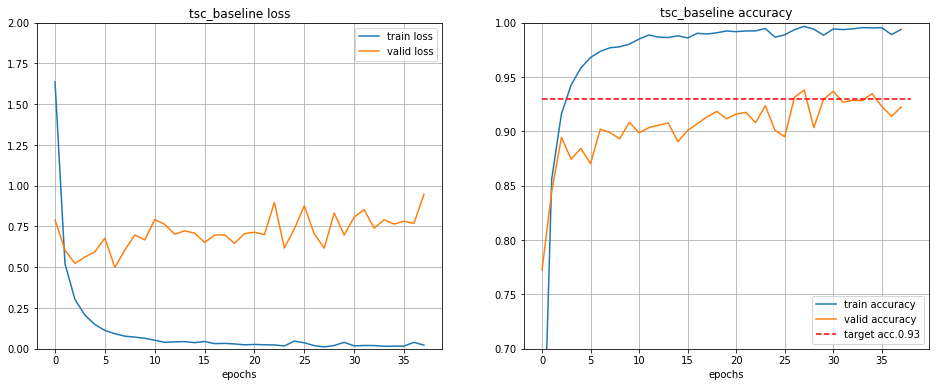

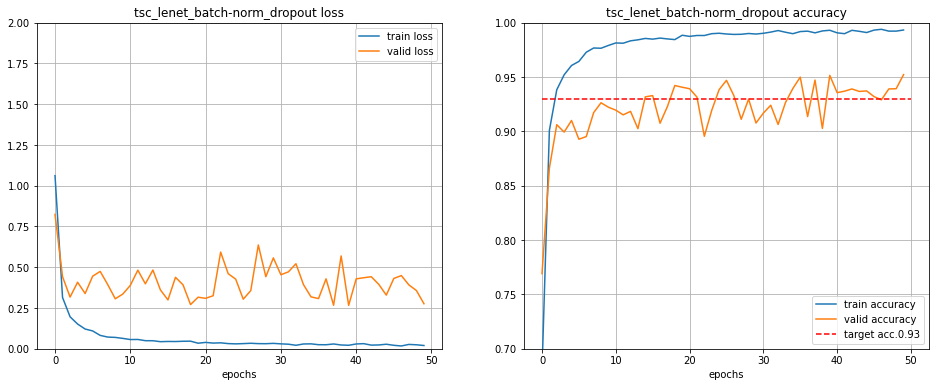

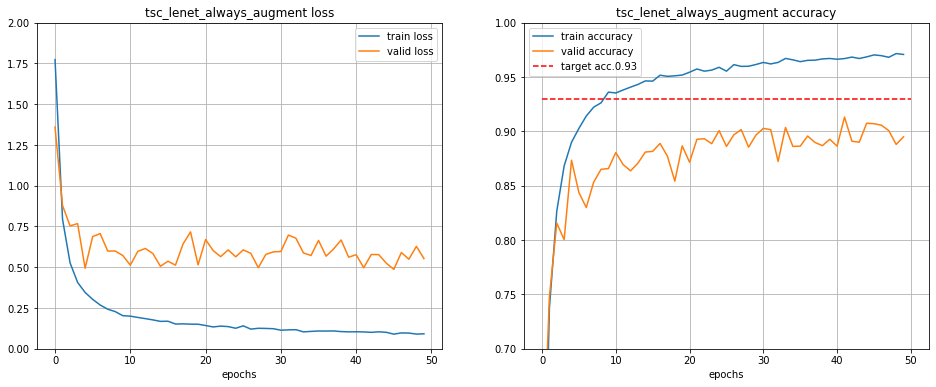

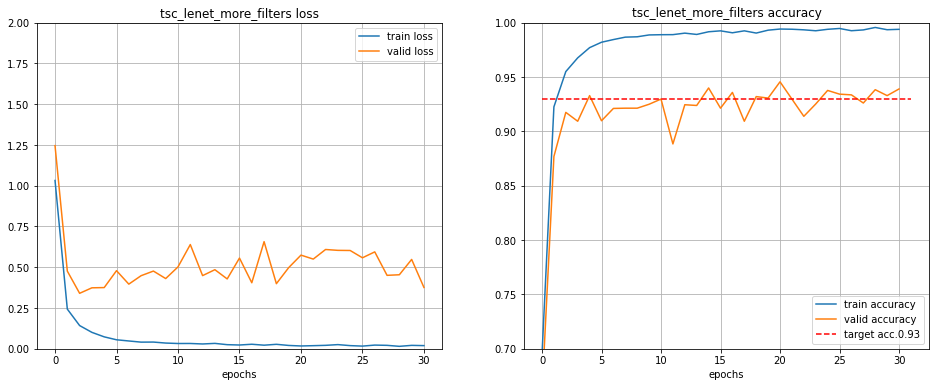

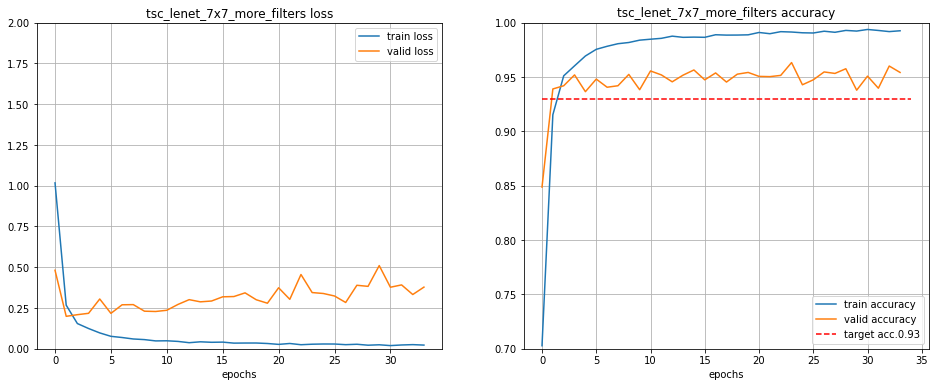

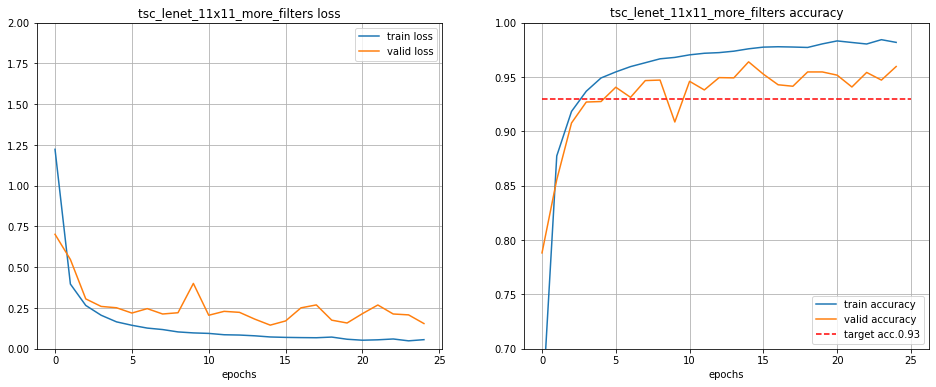

In [42]:
# Training summary/plots generation (collected in history dict)

from functools import reduce

summaries = {
    nn: {
        metric: {
            "train": reduce(lambda x, y: x + y, [x.history[metric] for x in history]),
            "valid": reduce(
                lambda x, y: x + y, [x.history[f"val_{metric}"] for x in history]
            ),
        }
        for metric in ["loss", "accuracy"]
    }
    for nn, history in history.items()
}

for nn, summary in summaries.items():

    plt.figure(figsize=(16, 6))

    for metric, ax in zip(
        summary.keys(), [plt.subplot(1, 2, idx) for idx in range(1, 3)]
    ):
        for set_label, values in summary[metric].items():
            ax.plot(values, label=f"{set_label} {metric}")
            ax.set_xlabel("epochs")
            ax.grid(visible=True)
            ax.set_title(f"{nn} {metric}")
        if metric == "accuracy":
            ax.set_ylim((0.7, 1))
            ax.hlines(
                0.93,
                0,
                len(values),
                color="red",
                linestyle="dashed",
                label="target acc.0.93",
            )
        else:
            ax.set_ylim((0, 2))
        ax.legend()
    # Saving the figure to a file (png)
    plt.savefig(f"./output/{nn}_training_session.png")

### Architecture/model comparison

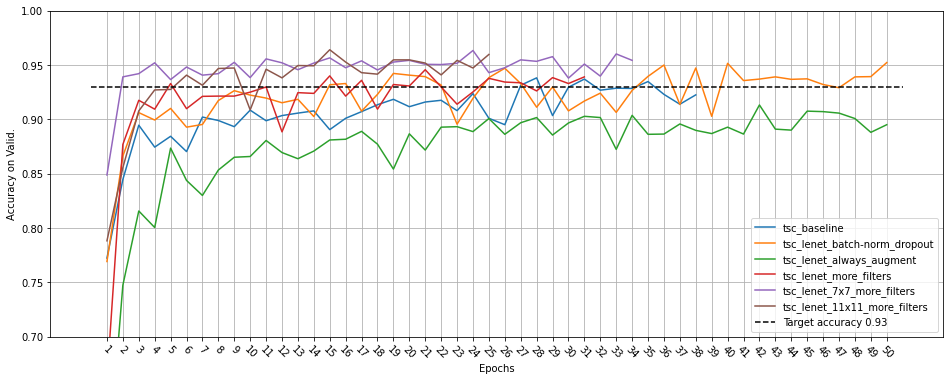

In [43]:
# Accuracy evolution per epoch.  model

plt.figure(figsize=(16, 6))
max_epochs = 1
for model_name, results in summaries.items():
    validation_accuracy = results["accuracy"]["valid"]
    max_epochs = max(1+len(validation_accuracy),  max_epochs)
    plt.xticks(range(1, max_epochs))
    plt.plot(range(1, 1+len(validation_accuracy)), validation_accuracy, label=f"{model_name}")
    
plt.ylim((0.7, 1))
plt.hlines(
                0.93,
                0,
                max_epochs,
                color="black",
                linestyle="dashed",
                label="Target accuracy 0.93",
            )
plt.xlabel("Epochs")
plt.ylabel("Accuracy on Valid.")
plt.xticks(rotation=-45)
plt.grid()
plt.legend()
plt.savefig(f"./output/models_comparison.png")



In [44]:
# Add a visualization of a monotonous increase keeping only 
# the epochs where the accuracy on the validation increases 
# compared to last best reached accuracy  

In [45]:
# Accuracy on train, validation (and test) sets

def accuracy_classes(prediction, gt):
    assert len(prediction) == len(gt)
    return np.sum(prediction == gt) / len(gt)


def accuracy(prediction, gt):
    return accuracy_classes(np.argmax(prediction, axis=1), gt)

# TODO -> add pred. accuracy to the model
for _, network in networks.items(): 
    print(f"\n{network._name}:\n")
    print(f"  Accuracy on the Train set =  {accuracy(network.pred_model(X_train), y_train)}")
    print(f"  Accuracy on the Valid. set = {accuracy(network.pred_model(X_valid), y_valid)}")
    # Test set accuracy
    print(f"  Accuracy on the Test set = {accuracy(network.pred_model(X_test), y_test)}")


tsc_baseline:

  Accuracy on the Train set =  0.9993390614672836
  Accuracy on the Valid. set = 0.9380952380952381
  Accuracy on the Test set = 0.9314330958036421

tsc_lenet_batch-norm_dropout:

  Accuracy on the Train set =  0.9999425270841116
  Accuracy on the Valid. set = 0.9521541950113379
  Accuracy on the Test set = 0.940855106888361

tsc_lenet_always_augment:

  Accuracy on the Train set =  0.9903158136728067
  Accuracy on the Valid. set = 0.8950113378684807
  Accuracy on the Test set = 0.8909738717339667

tsc_lenet_more_filters:

  Accuracy on the Train set =  0.9994827437570045
  Accuracy on the Valid. set = 0.9455782312925171
  Accuracy on the Test set = 0.9259699129057799

tsc_lenet_7x7_more_filters:

  Accuracy on the Train set =  0.9994252708411161
  Accuracy on the Valid. set = 0.963265306122449
  Accuracy on the Test set = 0.9397466349960412

tsc_lenet_11x11_more_filters:

  Accuracy on the Train set =  0.9975286646167993
  Accuracy on the Valid. set = 0.963945578231292

## Select the "best" model (based on validation)

In [46]:
# Select the model based on the validation perf.
model_acc_sorted = sorted([ (model, accuracy(network.pred_model(X_valid), y_valid)) for model, network in networks.items()], key= lambda x:x[1], reverse=True)
model_acc_sorted

[('tsc_lenet_11x11_more_filters', 0.9639455782312926),
 ('tsc_lenet_7x7_more_filters', 0.963265306122449),
 ('tsc_lenet_batch-norm_dropout', 0.9521541950113379),
 ('tsc_lenet_more_filters', 0.9455782312925171),
 ('tsc_baseline', 0.9380952380952381),
 ('tsc_lenet_always_augment', 0.8950113378684807)]

## Inspect validation perf.

In [47]:
model = networks[model_acc_sorted[0][0]]
print(f"Seletected model -> {model.name}")

Seletected model -> tsc_lenet_11x11_more_filters


In [48]:
model.predict(X_valid)[:2]

array([[5.29830446e-09, 1.14565023e-06, 6.74977652e-13, 1.31064965e-07,
        5.73442162e-12, 8.44481689e-12, 2.31128559e-01, 2.72431926e-08,
        3.47719265e-07, 9.99746685e-09, 7.07472275e-19, 6.32833689e-07,
        4.78950268e-10, 2.48756848e-10, 4.94278938e-22, 9.49257373e-15,
        3.52436982e-05, 6.50768784e-23, 1.27527933e-10, 5.71554412e-15,
        4.34662750e-09, 2.87281468e-16, 3.42736276e-15, 6.87735242e-13,
        3.09424822e-13, 6.81101529e-12, 4.47696926e-14, 1.28148360e-12,
        1.00363957e-06, 9.26006064e-15, 1.09649484e-10, 4.18902874e-19,
        4.04291928e-01, 2.31520104e-07, 6.95486854e-12, 1.19403909e-08,
        2.15267778e-06, 1.79790315e-11, 1.57135838e-09, 1.81184220e-07,
        3.01575369e-08, 3.64506125e-01, 3.22296401e-05],
       [1.02596975e-09, 8.15773319e-07, 6.89767774e-12, 1.41384277e-07,
        2.67287564e-11, 2.40353570e-10, 3.86402458e-01, 1.72467143e-08,
        4.70547519e-07, 1.23462751e-09, 4.35961509e-19, 1.92432186e-08,
       

In [49]:
def misclassified(model, images, gt):
    """ Returns the mis-classified item indices zipped
        with the predicted and the correct ground truth label 
    
    :param model: model to use for prediction
    :param images: images as a np.array with shape (N, 32, 32,3) 
    :param gt: label as integer of shape (N,)
    """
    predictions = np.argmax(model.predict(images), axis=1) # perform  prediction with the given modl
    misclassified_indices =  np.argwhere(predictions != gt).flatten()
    return np.array(list(zip(misclassified_indices, predictions[misclassified_indices], gt[misclassified_indices])))

In [50]:
valid_misclassified = misclassified(model, X_valid, y_valid)

In [51]:
print(len(valid_misclassified))

159


In [52]:
from traffic_sign_classifier.utils import load_signnames
index2label = load_signnames("./traffic-signs-data/signnames.csv")

In [53]:
from collections import defaultdict

valid_misclassified_by_pred = defaultdict(lambda:[]) # misclassified grouped by predicted class
valid_misclassified_by_gt = defaultdict(lambda:[]) # misclassified grouped by gt clas
for index, prediction, gt in valid_misclassified:
    valid_misclassified_by_pred[prediction].append((index, gt))
    valid_misclassified_by_gt[gt].append((index, prediction))
    # print(f"{index} pred.: {index2label.get(prediction)}, gt: {index2label.get(gt)}")

### Misclassification stats.

In [54]:
# Sorting the missclassification by category (first those with high error rate)
top_mis_nbr = 5 # number of the top misclassified category to summarize
sorted_misclassified = sorted([ (category, misclassifications)
                                          for category, misclassifications in valid_misclassified_by_gt.items()],
                                          key=lambda x: len(x[1]), reverse=True)
for category, misclassification in sorted_misclassified[:top_mis_nbr]:
    print(f"\n(id: {category}) {index2label.get(category)}, {len(misclassification)} incorrectly classified:")
    # Groupping the misclassification by predicted class
    grp = defaultdict(lambda:[])
    for item, predicted in misclassification:
        grp[predicted].append(item)
    for prediction, items in  grp.items():
        print(f"* as {class2label.get(prediction, prediction)} -> {len(items)} time(s)!")
        
    


(id: 21) Double curve, 19 incorrectly classified:
* as Traffic signals -> 1 time(s)!
* as Road narrows on the right -> 1 time(s)!
* as Road work -> 3 time(s)!
* as Wild animals crossing -> 11 time(s)!
* as Beware of ice/snow -> 2 time(s)!
* as Dangerous curve to the left -> 1 time(s)!

(id: 40) Roundabout mandatory, 17 incorrectly classified:
* as Go straight or right -> 9 time(s)!
* as Speed limit (100km/h) -> 1 time(s)!
* as Double curve -> 1 time(s)!
* as End of all speed and passing limits -> 4 time(s)!
* as Right-of-way at the next intersection -> 1 time(s)!
* as Dangerous curve to the right -> 1 time(s)!

(id: 34) Turn left ahead, 13 incorrectly classified:
* as Keep right -> 13 time(s)!

(id: 20) Dangerous curve to the right, 13 incorrectly classified:
* as Children crossing -> 2 time(s)!
* as Bicycles crossing -> 3 time(s)!
* as Double curve -> 1 time(s)!
* as Beware of ice/snow -> 2 time(s)!
* as Priority road -> 1 time(s)!
* as Road work -> 3 time(s)!
* as Slippery road -> 1

## Misclassified sample visualization.

Visualizing the most freq. misclassified categories/classes

In [55]:
# most frequently missed categories
most_misclassified_categs, _ = zip(*sorted_misclassified)

In [56]:
# Remark the last contrast (dark images) (histogram equalization could be part of the processing for the )
# Also for the 

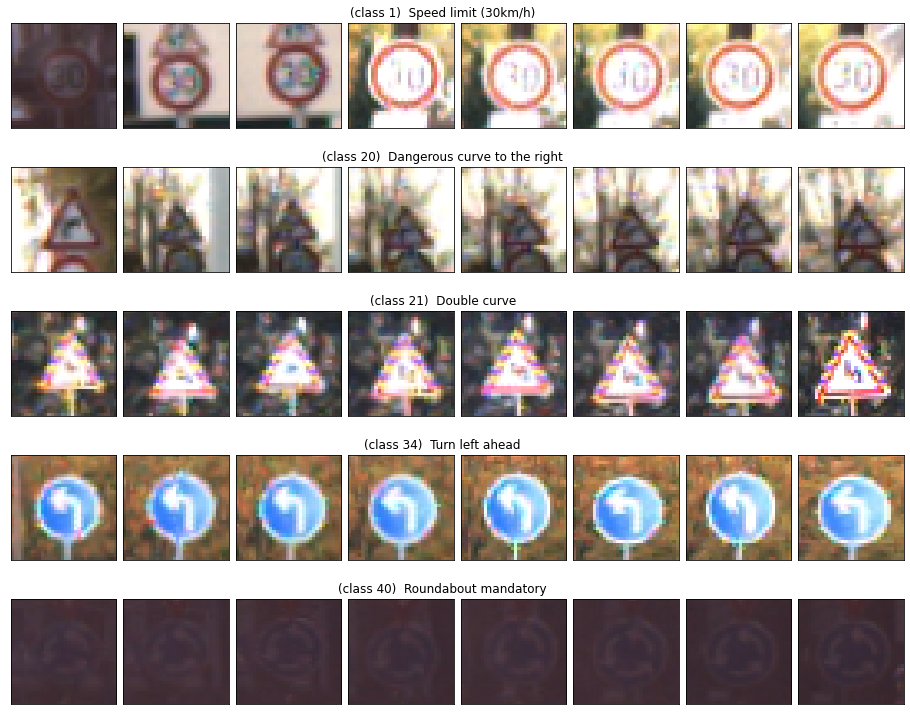

In [57]:
# TODO: fix subfigure bug
grid_visu(X_valid[valid_misclassified[:, 0]], labels=y_valid[valid_misclassified[:, 0]],
                 sample_size=8, categories= most_misclassified_categs[:top_mis_nbr], label_to_name=class2label,
         output_dir_path="./output/misclassified")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [132]:
from typing import List
from glob import glob

import cv2

test_paths = [image_path for image_path in glob("./examples/test_sample/*.png")]

# For convinience and batch/faster prediction that we resize the new image to (32x32)
# 32x32 resizing is part of the preprocessing for prediction though!

def extract_test_categ(image_path) -> int:
    """ Extract test category/class from image path. 
        convension for naming the files [class]_[id].extension
    """
    return int(os.path.split(os.path.basename(image_path))[-1].split("_")[0])

def load_data(paths: List[str], label_extractor=extract_test_categ):
    """ A helper loading  the images from a list of paths 
    and extract the label from their path using the label extractor
    """ 
    for path in sorted(paths):
        yield  path, cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), (32,32)) , label_extractor(path)

In [113]:
# sample_test_image = cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB)
# sample_test_image.reshape( [1] , sample_test_image.shape()
# As the resizing and scaling 
model.predict(np.expand_dims(cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB), axis=0))

array([[6.2989583e-12, 7.2144241e-05, 7.3543698e-02, 5.7449000e-05,
        9.2900027e-10, 9.2628866e-01, 1.4891013e-09, 1.5658661e-05,
        2.8607174e-11, 4.4670065e-15, 4.3882475e-09, 2.3373024e-09,
        1.3786401e-15, 2.2545770e-12, 1.6540881e-14, 9.3444071e-16,
        1.6817507e-12, 1.7444759e-20, 2.7274721e-15, 1.1628998e-14,
        2.9481683e-14, 1.1231368e-09, 2.0475089e-16, 2.9378036e-12,
        1.0195417e-11, 1.0443717e-09, 1.0103357e-17, 1.7598249e-17,
        3.8130259e-09, 2.7471162e-13, 5.1410753e-10, 7.2662439e-11,
        3.0134146e-12, 5.0185986e-15, 6.4836925e-12, 5.0392146e-10,
        3.2348865e-10, 1.7410467e-11, 2.2110491e-05, 2.3400766e-17,
        2.9012179e-07, 1.7059397e-11, 8.0423010e-09]], dtype=float32)

In [114]:
model.predict(cv2.cvtColor(cv2.imread(test_paths[-1]), cv2.COLOR_BGR2RGB))

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[6.29896959e-12, 7.21442339e-05, 7.35437572e-02, 5.74489968e-05,
        9.29002042e-10, 9.26288545e-01, 1.48910106e-09, 1.56586884e-05,
        2.86071705e-11, 4.46702349e-15, 4.38824710e-09, 2.33730679e-09,
        1.37863464e-15, 2.25456806e-12, 1.65408492e-14, 9.34440606e-16,
        1.68175369e-12, 1.74447577e-20, 2.72747192e-15, 1.16289975e-14,
        2.94816797e-14, 1.12314102e-09, 2.04750879e-16, 2.93780885e-12,
        1.01954166e-11, 1.04437359e-09, 1.01033172e-17, 1.75981782e-17,
        3.81302590e-09, 2.74711596e-13, 5.14107479e-10, 7.26624316e-11,
        3.01341439e-12, 5.01859821e-15, 6.48369162e-12, 5.03922404e-10,
        3.23488625e-10, 1.74105019e-11, 2.21105711e-05, 2.34008535e-17,
        2.90122045e-07, 1.70594285e-11, 8.04230016e-09]], dtype=float32)>

In [140]:
test_paths, test_images , test_labels =zip(* load_data(test_paths))
print(len(test_paths))
print(test_paths)

19
('./examples/test_sample/13_1.png', './examples/test_sample/13_2.png', './examples/test_sample/13_3.png', './examples/test_sample/17_1.png', './examples/test_sample/17_2.png', './examples/test_sample/18_1.png', './examples/test_sample/18_2.png', './examples/test_sample/2_1.png', './examples/test_sample/33_1.png', './examples/test_sample/33_2.png', './examples/test_sample/35_1.png', './examples/test_sample/35_2.png', './examples/test_sample/35_3.png', './examples/test_sample/35_4.png', './examples/test_sample/38_1.png', './examples/test_sample/38_2.png', './examples/test_sample/3_1.png', './examples/test_sample/3_2.png', './examples/test_sample/3_3.png')


In [116]:
# Generate md image-set

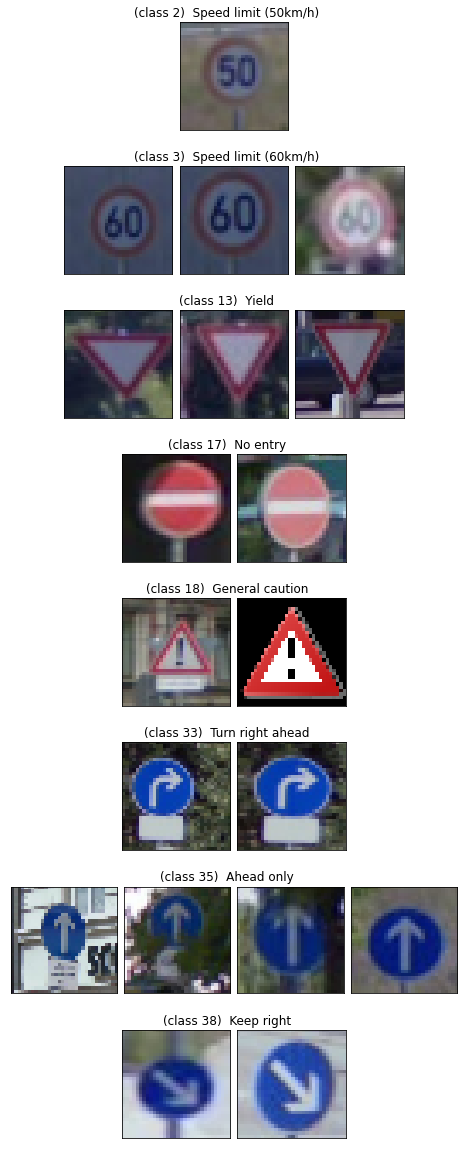

In [117]:
# Todo center the visualization
grid_visu(test_images, test_labels, sample_size=4, label_to_name=class2label, categories_per_fig=8,  output_dir_path="./output/ext_new")

### Predict the Sign Type for Each Image

In [118]:
# To move to LeNet (class) as a method
from typing import Iterable
from traffic_sign_classifier.nn.utils import softmax

def predict_paths(paths: Iterable[str]=test_paths, top_k=5):
    """ Predict a list of image paths """
    for path, image, label  in load_data(paths):
        image = image.reshape([1] + list(image.shape))
        prediction = (model.predict(image)).flatten()
        pred_categ = np.argmax(prediction)
        print(f" {path}: gt: {label} -> predicted category ({pred_categ}:{class2label[pred_categ]}) ")
        if top_k is not None:
            for softmax_output, category in sorted(zip(softmax(prediction), range(len(prediction))), reverse=True)[:top_k]:
                print(f"        {category} {softmax_output} {class2label[category]} -> {category}")
        yield path, label, pred_categ
        

In [119]:
ext_paths, ext_gt, ext_pred = zip(*predict_paths(test_paths))

 ./examples/test_sample/13_1.png: gt: 13 -> predicted category (13:Yield) 
        13 0.06078681722283363 Yield -> 13
        42 0.02236221916973591 End of no passing by vehicles over 3.5 metric tons -> 42
        41 0.02236221916973591 End of no passing -> 41
        40 0.02236221916973591 Roundabout mandatory -> 40
        39 0.02236221916973591 Keep left -> 39
 ./examples/test_sample/13_2.png: gt: 13 -> predicted category (13:Yield) 
        13 0.060786813497543335 Yield -> 13
        42 0.02236221916973591 End of no passing by vehicles over 3.5 metric tons -> 42
        41 0.02236221916973591 End of no passing -> 41
        40 0.02236221916973591 Roundabout mandatory -> 40
        39 0.02236221916973591 Keep left -> 39
 ./examples/test_sample/13_3.png: gt: 13 -> predicted category (13:Yield) 
        13 0.06078673154115677 Yield -> 13
        35 0.022362252697348595 Ahead only -> 35
        42 0.022362221032381058 End of no passing by vehicles over 3.5 metric tons -> 42
        41 

In [141]:
print(test_paths)

('./examples/test_sample/13_1.png', './examples/test_sample/13_2.png', './examples/test_sample/13_3.png', './examples/test_sample/17_1.png', './examples/test_sample/17_2.png', './examples/test_sample/18_1.png', './examples/test_sample/18_2.png', './examples/test_sample/2_1.png', './examples/test_sample/33_1.png', './examples/test_sample/33_2.png', './examples/test_sample/35_1.png', './examples/test_sample/35_2.png', './examples/test_sample/35_3.png', './examples/test_sample/35_4.png', './examples/test_sample/38_1.png', './examples/test_sample/38_2.png', './examples/test_sample/3_1.png', './examples/test_sample/3_2.png', './examples/test_sample/3_3.png')


In [120]:
# Predicition to md
# TODO: mv as utils helper function 
from IPython.display import Markdown, display
from typing import Dict

def render_pred_cell(pred, actual, class2label:Dict):
    """ Render pred cell with correct vs not background"""
    if pred == actual :
        return  f'<p style="background:green; opacity=0.3"> {pred},  {class2label.get(pred, pred)} </p>'
    return  f'<p style="background:red; opacity=0.3"> {pred}, {class2label.get(pred, pred)} </p>'

header = "\n".join(["| Image | Ground truth | Prediction | ","|:-----:|:------------:|:----------:|"])
rows  = []
for path_, gt_, pred_ in sorted(zip(ext_paths, ext_gt, ext_pred)):
    rows.append(f"| {path_} | {gt_}, {class2label[gt_]}|  {render_pred_cell(pred_, gt_, class2label)}|")

table = "\n".join([header]+rows)                
display(Markdown(table))
print(table)

| Image | Ground truth | Prediction | 
|:-----:|:------------:|:----------:|
| ./examples/test_sample/13_1.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/13_2.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/13_3.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/17_1.png | 17, No entry|  <p style="background:green; opacity=0.3"> 17,  No entry </p>|
| ./examples/test_sample/17_2.png | 17, No entry|  <p style="background:green; opacity=0.3"> 17,  No entry </p>|
| ./examples/test_sample/18_1.png | 18, General caution|  <p style="background:red; opacity=0.3"> 19, Dangerous curve to the left </p>|
| ./examples/test_sample/18_2.png | 18, General caution|  <p style="background:green; opacity=0.3"> 18,  General caution </p>|
| ./examples/test_sample/2_1.png | 2, Speed limit (50km/h)|  <p style="background:red; opacity=0.3"> 5, Speed limit (80km/h) </p>|
| ./examples/test_sample/33_1.png | 33, Turn right ahead|  <p style="background:red; opacity=0.3"> 34, Turn left ahead </p>|
| ./examples/test_sample/33_2.png | 33, Turn right ahead|  <p style="background:red; opacity=0.3"> 40, Roundabout mandatory </p>|
| ./examples/test_sample/35_1.png | 35, Ahead only|  <p style="background:green; opacity=0.3"> 35,  Ahead only </p>|
| ./examples/test_sample/35_2.png | 35, Ahead only|  <p style="background:red; opacity=0.3"> 36, Go straight or right </p>|
| ./examples/test_sample/35_3.png | 35, Ahead only|  <p style="background:green; opacity=0.3"> 35,  Ahead only </p>|
| ./examples/test_sample/35_4.png | 35, Ahead only|  <p style="background:green; opacity=0.3"> 35,  Ahead only </p>|
| ./examples/test_sample/38_1.png | 38, Keep right|  <p style="background:green; opacity=0.3"> 38,  Keep right </p>|
| ./examples/test_sample/38_2.png | 38, Keep right|  <p style="background:green; opacity=0.3"> 38,  Keep right </p>|
| ./examples/test_sample/3_1.png | 3, Speed limit (60km/h)|  <p style="background:green; opacity=0.3"> 3,  Speed limit (60km/h) </p>|
| ./examples/test_sample/3_2.png | 3, Speed limit (60km/h)|  <p style="background:red; opacity=0.3"> 38, Keep right </p>|
| ./examples/test_sample/3_3.png | 3, Speed limit (60km/h)|  <p style="background:red; opacity=0.3"> 5, Speed limit (80km/h) </p>|

| Image | Ground truth | Prediction | 
|:-----:|:------------:|:----------:|
| ./examples/test_sample/13_1.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/13_2.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/13_3.png | 13, Yield|  <p style="background:green; opacity=0.3"> 13,  Yield </p>|
| ./examples/test_sample/17_1.png | 17, No entry|  <p style="background:green; opacity=0.3"> 17,  No entry </p>|
| ./examples/test_sample/17_2.png | 17, No entry|  <p style="background:green; opacity=0.3"> 17,  No entry </p>|
| ./examples/test_sample/18_1.png | 18, General caution|  <p style="background:red; opacity=0.3"> 19, Dangerous curve to the left </p>|
| ./examples/test_sample/18_2.png | 18, General caution|  <p style="background:green; opacity=0.3"> 18,  General caution </p>|
| ./examples/test_sample/2_1.png | 2, Speed limit (50km/h)|  <p style="background:red; opacity=0.3"> 5, Speed lim

In [121]:
from traffic_sign_classifier.utils import accuracy_classes
correct_ext = np.sum(np.array(ext_pred)==np.array(ext_gt)) 
acc_ext = accuracy_classes(np.array(ext_pred), np.array(ext_gt))

print(f"The model was able to correctly guess {correct_ext} of the {len(ext_pred)} traffic signs, which gives an accuracy of {acc_ext:.2f}")

The model was able to correctly guess 12 of the 19 traffic signs, which gives an accuracy of 0.63


### Analyze Performance

In [122]:
print (f" accuracy on the new sample -> {100*accuracy_classes(np.array(ext_gt), np.array(ext_pred)):.2f}%")

 accuracy on the new sample -> 63.16%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [123]:
# predict the images (in batch)
prediction = model.predict(np.array(test_images))
top_k = tf.nn.top_k(softmax(prediction), k=5)
ext_probs = top_k.values
ext_classes = top_k.indices

In [124]:
zip( test_images, *zip(*(map(np.array, zip(ext_probs, ext_classes)))))

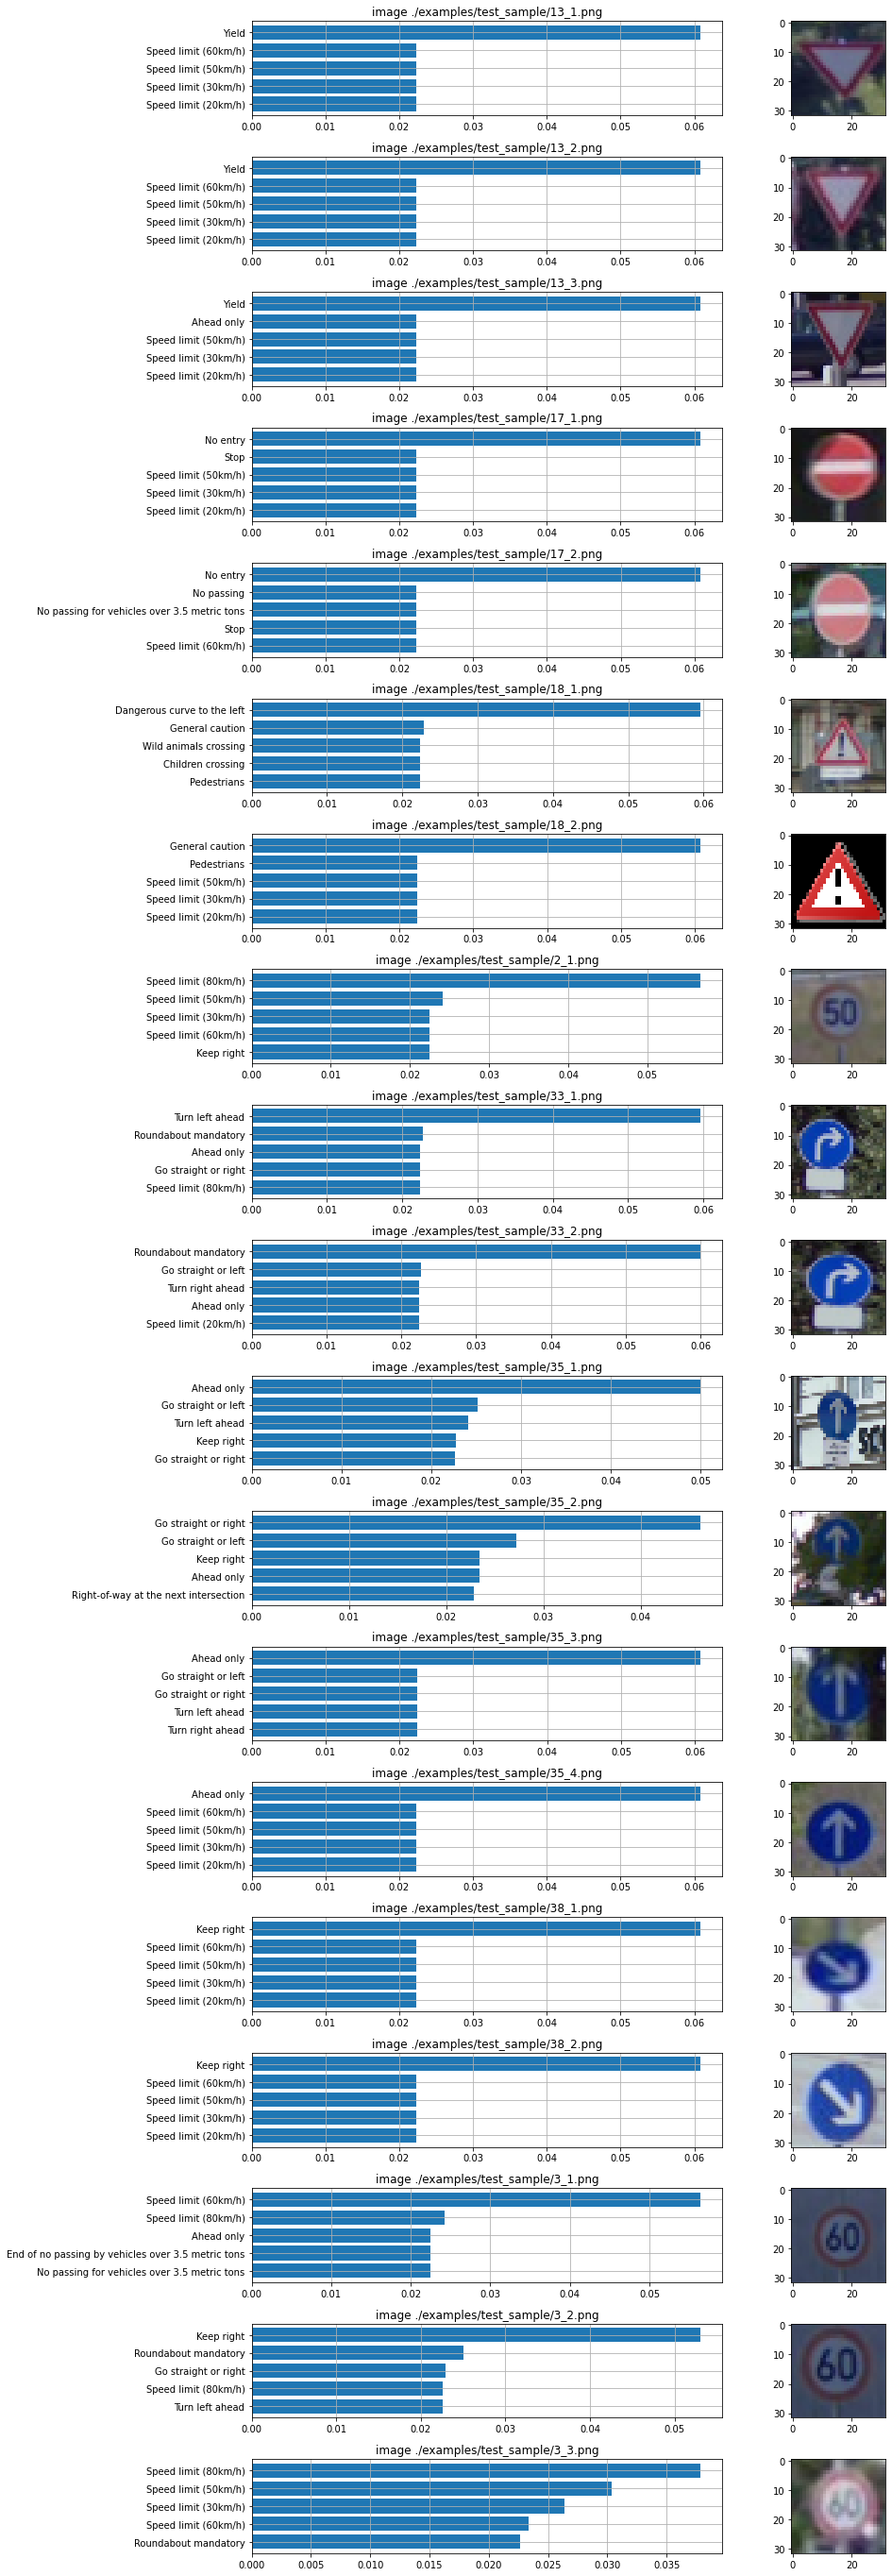

In [125]:
index = 1
plt.figure(figsize=(16, len(test_images)*2))
# TODO sort by classes (file name)
for image_file, test_image, probs, categs in zip(test_paths, test_images, *zip(*map(np.array, zip(ext_probs, ext_classes)))):
    ax = plt.subplot(len(test_images), 2, index)
    sorted_categs, sorted_probs = zip(*sorted(zip(categs, probs), key=lambda x: x [1]))
    categ_labels = [class2label.get(item, item) for item in sorted_categs]
    ax.barh(range(len(categ_labels))
            , sorted_probs, tick_label=categ_labels)
    ax.set_title(f"image {image_file}")
    ax.grid()
    index += 1
    ax_image = plt.subplot(len(test_images), 2, index)
    ax_image.imshow(test_image)
    index += 1
plt.tight_layout()
# TODO save the output
plt.savefig(f"./output/top_5_softmax_probs.png")

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images



In [126]:
for layer in model.pred_model.layers:
    print(layer.name)

input_6
resizing
rescaling
conv2d_10
batch_normalization_8
max_pooling2d_10
conv2d_11
batch_normalization_9
max_pooling2d_11
flatten_5
dense_15
dense_16
dense_17


In [127]:
from mpl_toolkits.axes_grid1 import ImageGrid
from traffic_sign_classifier.visualization import visualize_feature_map_output

def build_activation_model(model, layer_name):
    """ A helper to build the `activation` model 
        from the original(whole) model and the layer_name to inspect """
    return tf.keras.Model(
        model.pred_model.input, model.pred_model.get_layer(layer_name).output
    )

In [128]:
conv_layer_names =  [layer.name for layer in  model.pred_model.layers if  layer.name.startswith("conv")]

In [129]:
conv_layer_names

['conv2d_10', 'conv2d_11']

In [144]:
test_paths

('./examples/test_sample/13_1.png',
 './examples/test_sample/13_2.png',
 './examples/test_sample/13_3.png',
 './examples/test_sample/17_1.png',
 './examples/test_sample/17_2.png',
 './examples/test_sample/18_1.png',
 './examples/test_sample/18_2.png',
 './examples/test_sample/2_1.png',
 './examples/test_sample/33_1.png',
 './examples/test_sample/33_2.png',
 './examples/test_sample/35_1.png',
 './examples/test_sample/35_2.png',
 './examples/test_sample/35_3.png',
 './examples/test_sample/35_4.png',
 './examples/test_sample/38_1.png',
 './examples/test_sample/38_2.png',
 './examples/test_sample/3_1.png',
 './examples/test_sample/3_2.png',
 './examples/test_sample/3_3.png')

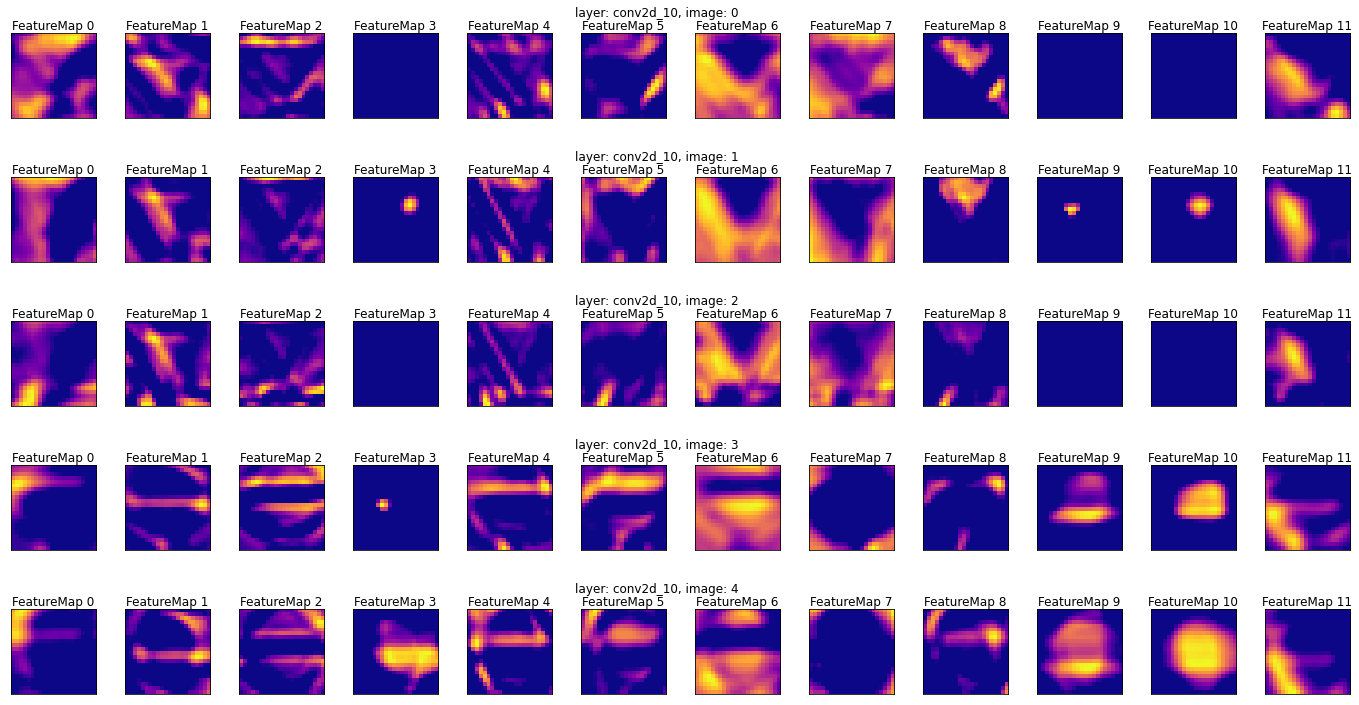

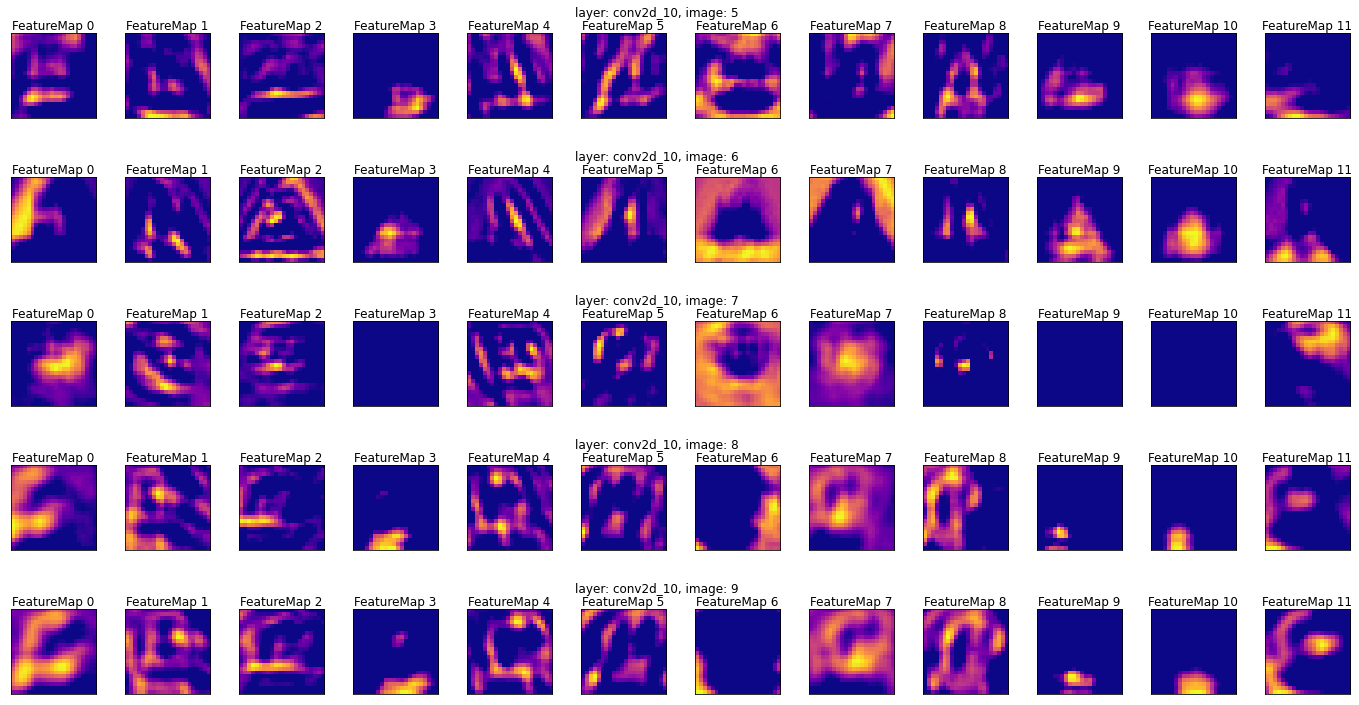

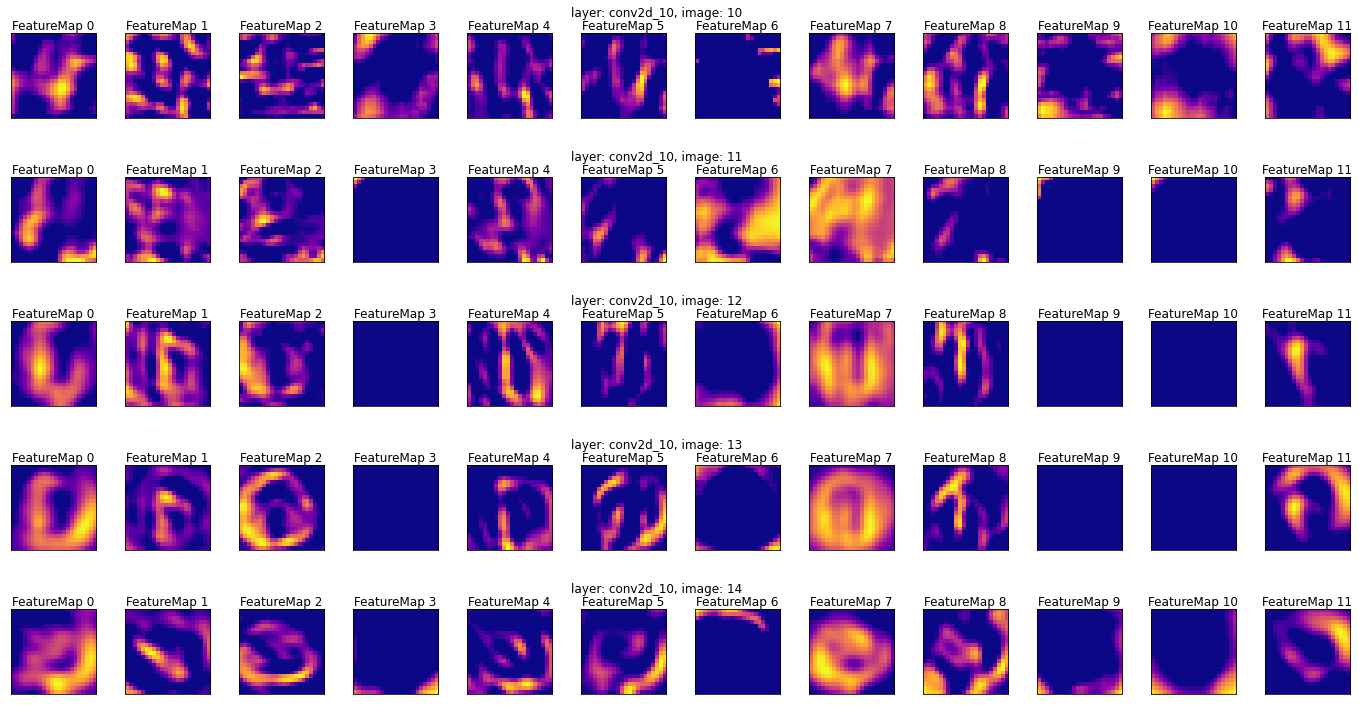

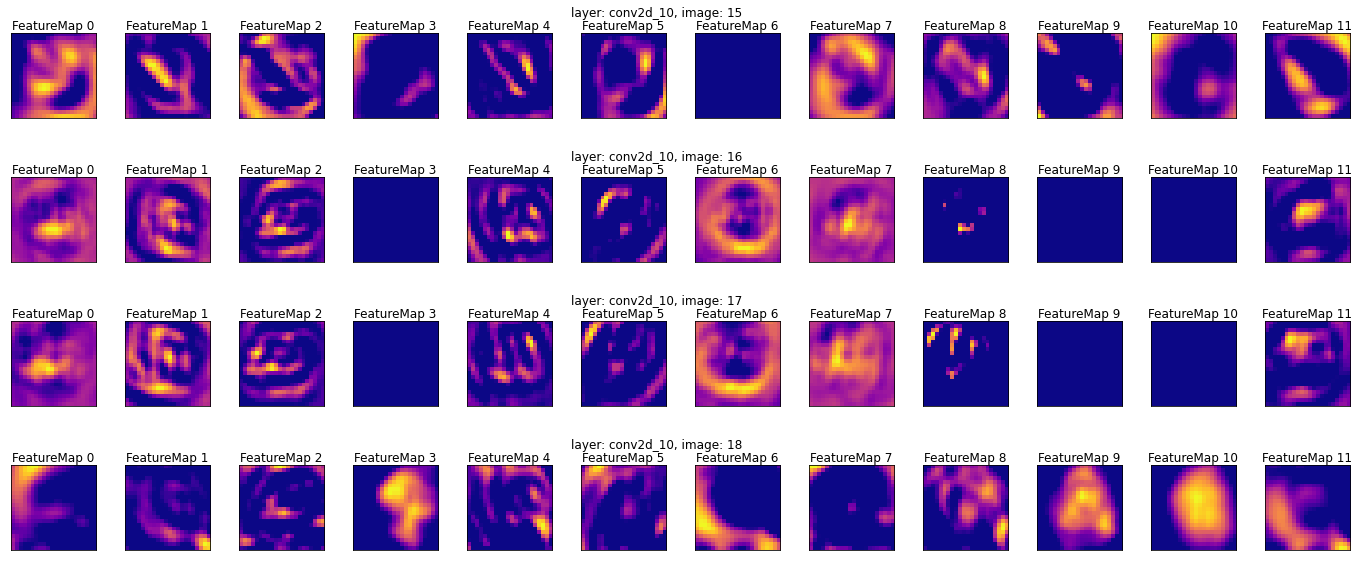

In [149]:
for layer_name in  conv_layer_names[:1]:
    visualize_feature_map_output(test_images, build_activation_model(model, layer_name),
                                 layer_name,  output_dir_path="./output/activation") # , paths=test_paths, labeler=extract_test_categ)